In [1]:
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
import random
import numpy as np
from src.model import ChannelMapper, ReferenceImageEncoder, MultiScaleReferenceImageEncoder, UNet2DDoubleAttentionConditionModel
from src.pipeline import PoseTransferPipeline
from datasets import load_from_disk
from src.transform import build_transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from diffusers import DDIMScheduler

[2023-09-06 13:38:04,798] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [19]:
path = "models/final/"
channel_mapper = ChannelMapper.from_pretrained(
    f"{path}/channel_mapper/",
    torch_dtype=torch.float16,
)
rie = MultiScaleReferenceImageEncoder.from_pretrained(
    f"{path}/rie/",
    torch_dtype=torch.float16,
    # use_cls_token=False,
    # use_time_emb=True,
)
unet = UNet2DDoubleAttentionConditionModel.from_pretrained(
    f"{path}/unet/",
    attn_heads_nums=8,
    # use_constraint_penalty=True,
    torch_dtype=torch.float16,
)
pipe = PoseTransferPipeline.from_pretrained(
    path,
    unet=unet,
    rie=rie,
    channel_mapper=channel_mapper,
    torch_dtype=torch.float16,
    # scheduler=DDIMScheduler(),
).to("cuda")

generator = torch.Generator(device="cuda").manual_seed(42)

The config attributes {'use_constraint_conv': False} were passed to UNet2DDoubleAttentionConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [4]:
def preprocess_segm(segm):
    segm = np.array(segm)[:, :, -1]
    segm = np.eye(25)[segm]
    segm = torch.from_numpy(segm).permute(2, 0, 1).cuda()
    segm = segm.unsqueeze(0).float().half()
    return segm

In [5]:
val_dataset = load_from_disk("datasets/DeepFashionPose/")["validation"]

/home/cbgmm/miniconda3/envs/hxenv/lib/python3.10/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [101]:
rand_idx = random.randint(0, len(val_dataset))
# rand_idx = 0

In [102]:
height = 512
width = 384
transform = build_transforms(height, width, is_train=False)
image = val_dataset[rand_idx]["to_image"].resize((width, height))
ref = val_dataset[rand_idx]["from_image"].resize((width, height))
org_segm = val_dataset[rand_idx]["to_densepose"].resize((width, height), 0)
segm = org_segm.resize((int(width / 8), int(height / 8)), 0)
segm = preprocess_segm(segm)

In [103]:
gen_image = pipe(
    ref=transform(ref).half().unsqueeze(0).expand(3, -1, -1, -1),
    cat=segm.expand(3, -1, -1, -1),
    height=height,
    width=width,
    ref_guidance_scale=5,
    cat_guidance_scale=5,
    num_inference_steps=50,
    generator=generator,
    cfg_type="cat_ref",
    cfg_decay=True,
    end_cfg=3,
).images

  0%|          | 0/51 [00:00<?, ?it/s]

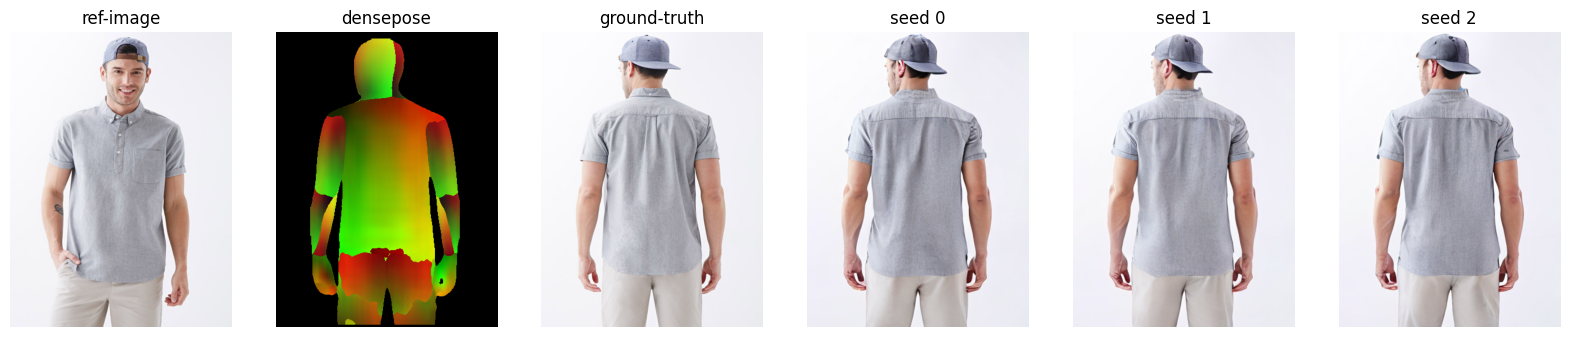

In [104]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 6, 1)
plt.imshow(ref)
plt.title("ref-image")
plt.axis("off")
plt.subplot(1, 6, 2)
plt.imshow(org_segm)
plt.title("densepose")
plt.axis("off")
plt.subplot(1, 6, 3)
plt.imshow(image)
plt.title("ground-truth")
plt.axis("off")
for i in range(3):
    plt.subplot(1, 6, 4 + i)
    plt.imshow(gen_image[i])
    plt.title(f"seed {i}")
    plt.axis("off")
plt.show()